In [1]:
using Plots; pyplot();
using DelimitedFiles, Distributions;
using AugmentedGaussianProcesses;

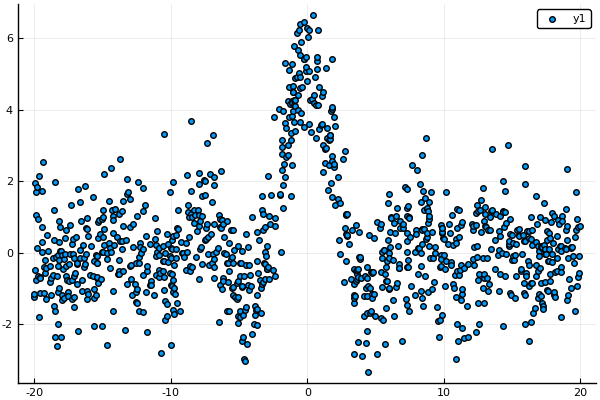

In [2]:
N = 1000
X = reshape((sort(rand(N)).-0.5).*40.0,N,1)
function latent(x)
    5.0.*sin.(x)./x
end
Y = (latent(X)+randn(N))[:];
scatter(X,Y)

In [3]:
# Run sparse classification with increasing number of inducing points
models = []
Ms = [4, 8, 16, 32, 64]
kernel = RBFKernel(1.0)
for (index, num_inducing) in enumerate(Ms)
    m = SparseGPRegression(X, Y, kernel=kernel,
        OptimizeIndPoints=true,Stochastic=false,Autotuning=true,m=num_inducing)
    println("Training with $(num_inducing) points")
    @time m.train(iterations=100)
    push!(models,m);
end

Training with 4 points
  3.954009 seconds (14.55 M allocations: 823.669 MiB, 8.27% gc time)
Training with 8 points
  0.116478 seconds (253.98 k allocations: 321.009 MiB, 21.52% gc time)
Training with 16 points
  0.323800 seconds (288.12 k allocations: 1.041 GiB, 21.51% gc time)
Training with 32 points
  1.239711 seconds (356.39 k allocations: 3.852 GiB, 26.06% gc time)
Training with 64 points
  4.279641 seconds (529.71 k allocations: 15.239 GiB, 23.05% gc time)


In [4]:
mfull = BatchGPRegression(X, Y, kernel=kernel,Autotuning=true)
println("Training with full model")
@time mfull.train(iterations=5);
push!(models,mfull);

Training with full model
  0.959360 seconds (1.17 M allocations: 421.610 MiB, 18.47% gc time)


In [5]:
function compute_Grid(model,nGrid=50)
    mins = -20
    maxs = 20
    Xplot = collect(range(mins[1],stop=maxs[1],length=nGrid))
#     Xplot = hcat([j for i in xlin, j in ylin][:],[i for i in xlin, j in ylin][:])
    y = model.predictproba(Xplot)
    return (y,Xplot)
    end;

In [6]:
function plotdata(X,Y)
    plot(X,Y,t=:scatter,alpha=0.33,markerstrokewidth=0.0,lab="",size=(300,500));
end;

In [7]:
function plotcontour(model,X,Y)
    nGrid = 100
    (predic,x) = compute_Grid(model,nGrid);
    plotdata(X,Y)
    if in(:m,fieldnames(typeof(model)))
        plot!(model.inducingPoints[:,1],zero(model.inducingPoints[:,1]),msize=2.0,color="black",t=:scatter,lab="")
    end
    return plot!(x,predic,title=(in(:m,fieldnames(typeof(model))) ? "M = $(model.m)" : "full"),color="red",lab="",linewidth=3.0)
end;

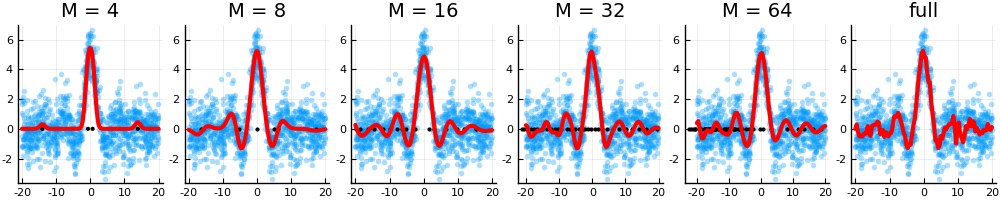

In [8]:
plot(broadcast(x->plotcontour(x,X,Y),models)...,layout=(1,length(models)),size=(1000,200))